# **Ecuador**

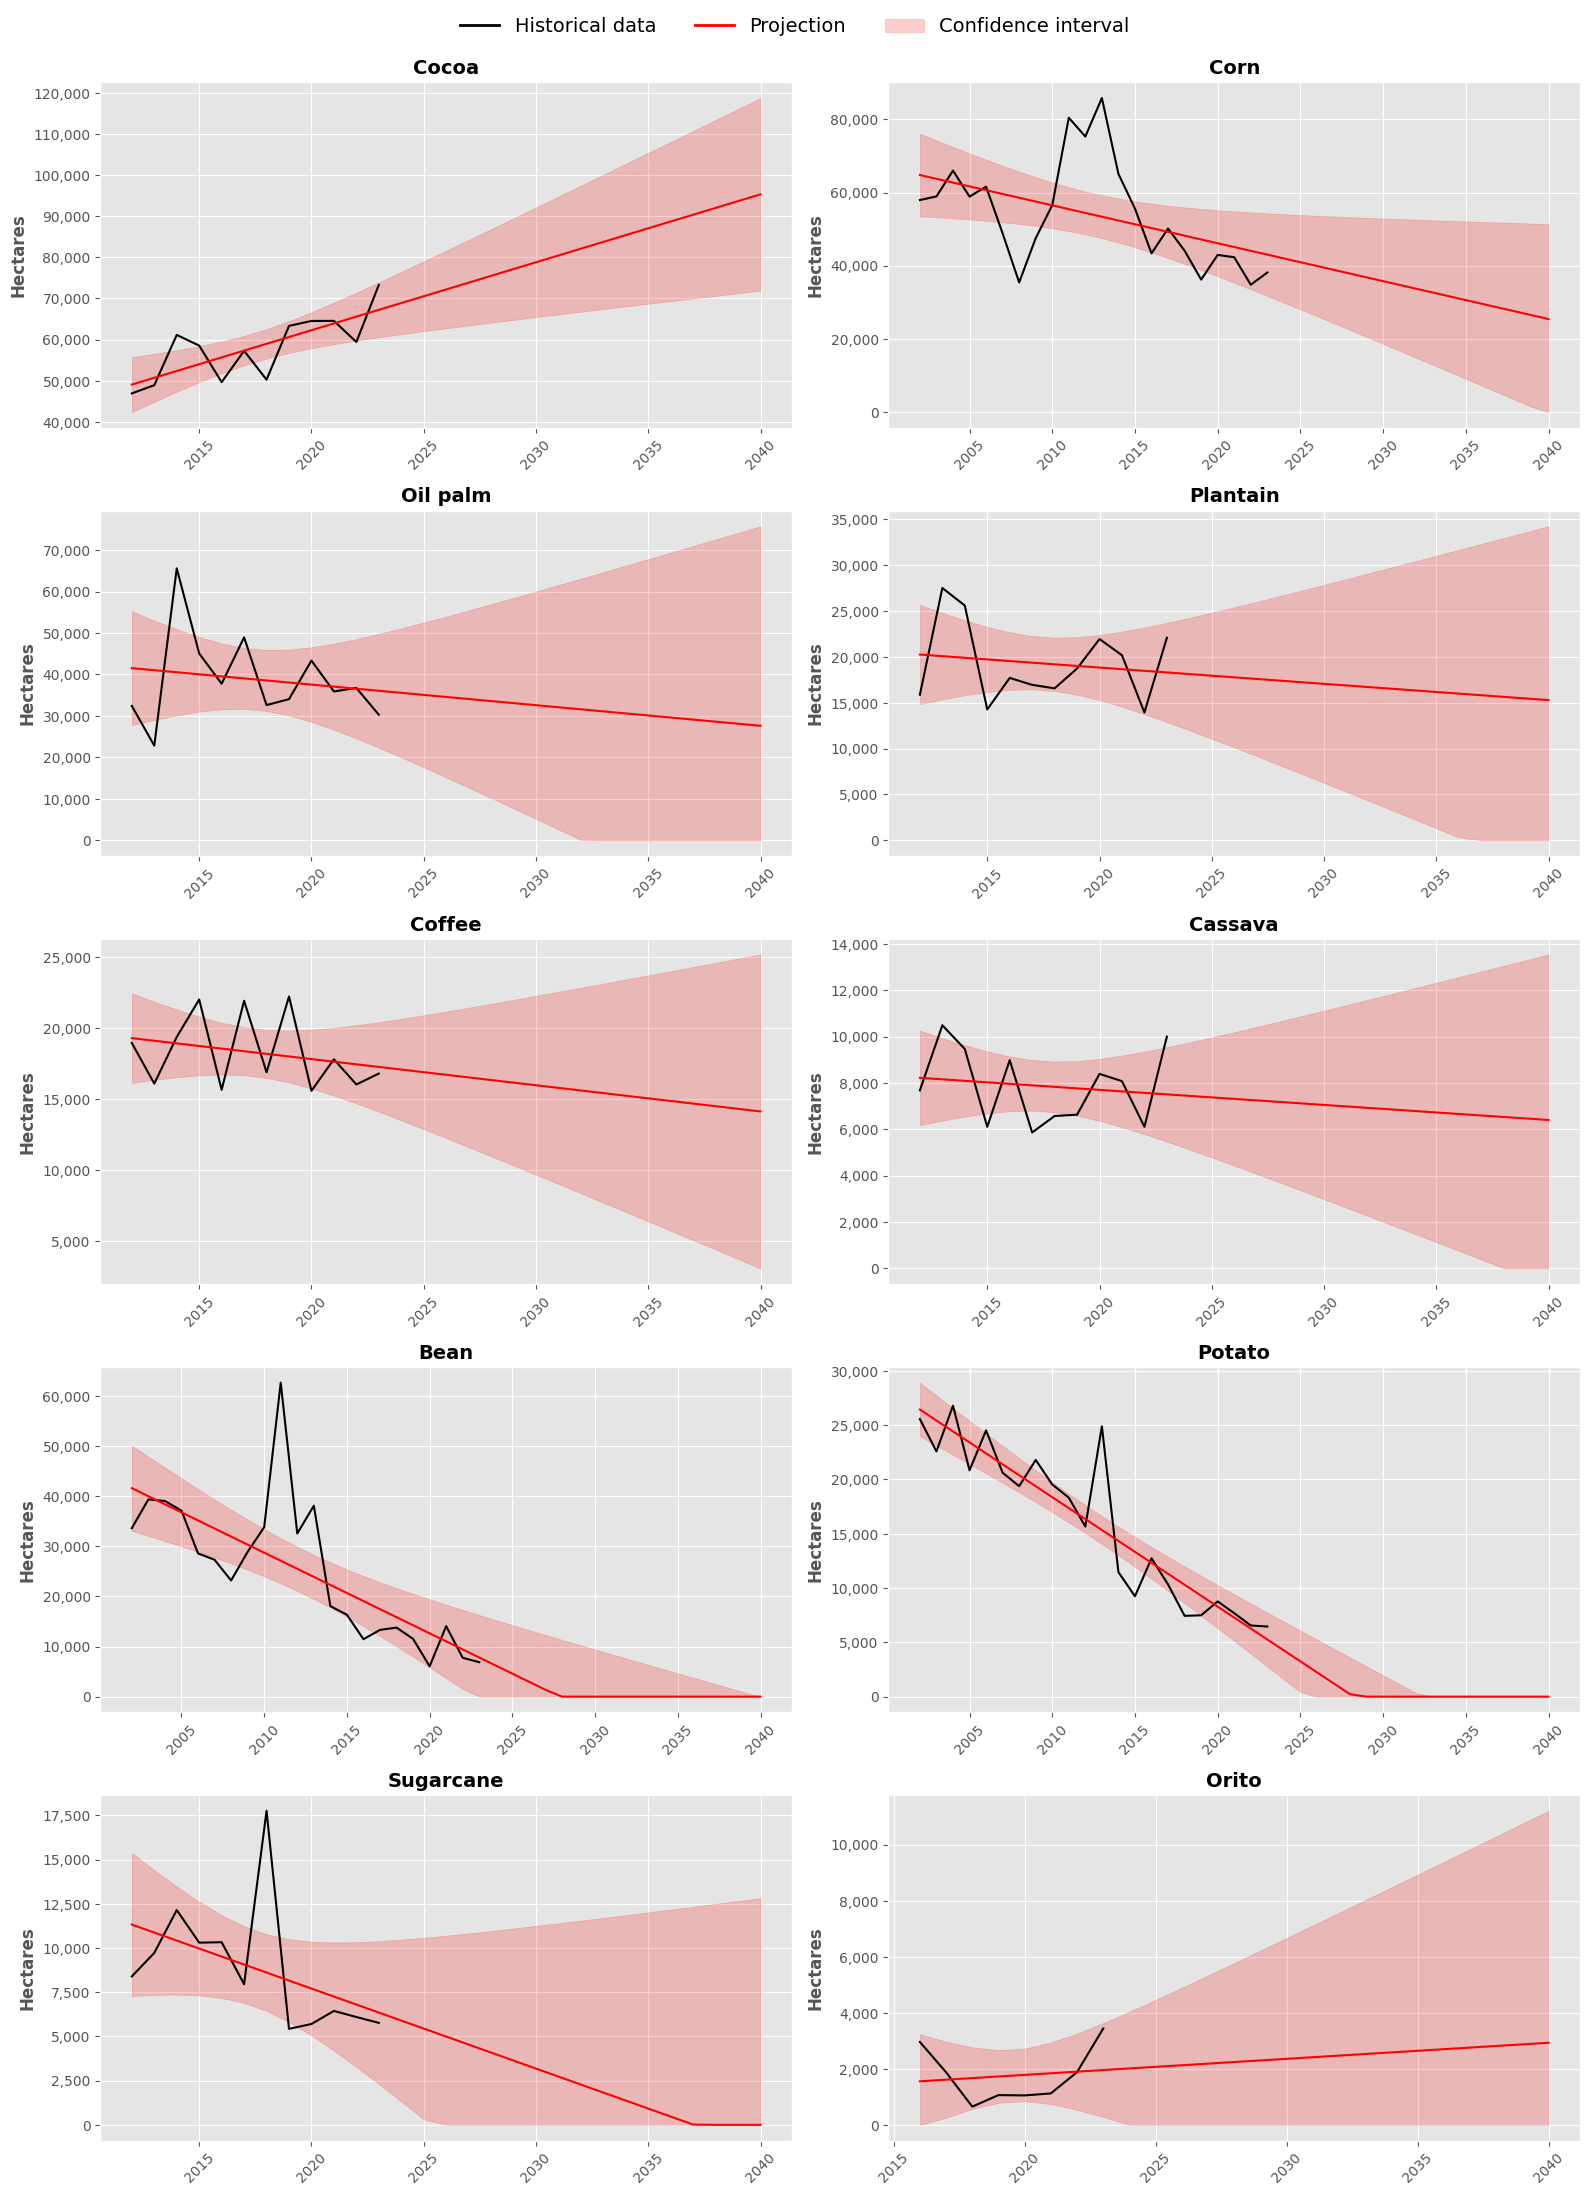

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
from matplotlib.patches import Patch

# Configurar estilo
plt.style.use('ggplot')

# Cargar el archivo Excel
file_path = '/content/drive/MyDrive/BID/datos_inicio/cultivos_ecuador.xlsx'
data = pd.read_excel(file_path)

# Traducciones de cultivos del español al inglés
traducciones = {
    "Palma Africana (Fruta Fresca)": "Oil palm",
    "Maíz": "Corn",
    "Arroz cáscara": "Rice",
    "Soya": "Soy",
    "Plátano (Fruta Fresca)": "Plantain",
    'Caña De Azúcar Para Azúcar (Tallo Fresco)': 'Sugarcane',
    'Caña De Azúcar Para Otros Usos (Tallo Fresco)': 'Sugarcane',
    "Yuca (Raíz Fresca)": "Cassava",
    "Cacao (Almendra Seca)": "Cocoa",
    "MARAÑÓN": "Cashew",
    "Café (Grano Oro)": "Coffee",
    'Sorgo en grano': 'Sorghum',
    'Trigo': 'Wheat',
    'Girasol': 'Sunflower',
    'Papa (Tubérculo Fresco)': 'Potato',
    'Frijol': 'Bean',
    'Alfalfa': 'Alfalfa',
    'Cebada': 'Barley',
    'Maíz Duro Seco (Grano Seco)': 'Corn',
    'Maíz Duro Choclo (En Choclo)': 'Corn',
    'Maíz Suave Choclo (En Choclo)': 'Corn',
    'Maíz Suave Seco (Grano Seco)': 'Corn',
    'Fréjol Seco (Grano Seco)': 'Bean',
    'Fréjol Tierno (En Vaina)': 'Bean',
    'Naranja (Fruta Fresca)': 'Orange',
    'Orito (Fruta Fresca)': 'Orito'
}

# Reemplazar las etiquetas en la columna 'Cultivo'
data['Cultivo'] = data['Cultivo'].replace(traducciones)

# Filtrar los datos del año 2023
data_2023 = data[data['Año'] == 2023]

# Obtener los 10 cultivos con mayor área en 2023
top_10_cultivos = data_2023.groupby('Cultivo')['Área'].sum().nlargest(10).index

# Filtrar la base de datos para los 10 cultivos principales
filtered_data_top10 = data[data['Cultivo'].isin(top_10_cultivos)]

# Agrupar por año y cultivo, sumando el área de todos los departamentos
cultivos_agrupados = filtered_data_top10.groupby(['Año', 'Cultivo'])['Área'].sum().reset_index()

# Función para formatear los números en miles
def thousands_formatter(x, pos):
    return f'{int(x):,}'

# Crear el subplot
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 22))  # Ajustar el tamaño de la figura para mejor distribución
axes = axes.ravel()  # Aplanar la matriz de ejes para iterar fácilmente

# Colores definidos
historical_color = 'black'
projection_color = 'red'

# Lista para almacenar los DataFrames con las proyecciones de cada cultivo
cultivos_dfs = []

for i, cultivo in enumerate(top_10_cultivos):
    # Datos para el cultivo actual
    cultivo_data = cultivos_agrupados[cultivos_agrupados['Cultivo'] == cultivo]

    # Filtrar los datos según el cultivo
    if cultivo not in ['Corn', 'Bean', 'Potato']:
        cultivo_data = cultivo_data[cultivo_data['Año'] >= 2012]

    # Filtrar los datos que no son ceros
    cultivo_data_filtered = cultivo_data[cultivo_data['Área'] != 0]

    # Regresión lineal
    X = cultivo_data_filtered['Año']
    y = cultivo_data_filtered['Área']
    X = sm.add_constant(X)  # Agregar una constante para el intercepto
    model = sm.OLS(y, X).fit()

    # Predicciones hasta el 2040
    years_pred = range(min(X['Año']), 2041)
    X_pred = sm.add_constant(years_pred)
    predictions = model.predict(X_pred)

    # Ajustar las predicciones para que no haya valores negativos
    predictions = predictions.clip(min=0)

    # Intervalo de confianza
    pred_ci = model.get_prediction(X_pred).conf_int()

    # Ajustar el intervalo de confianza para que no haya valores negativos
    pred_ci[:, 0] = pred_ci[:, 0].clip(min=0)
    pred_ci[:, 1] = pred_ci[:, 1].clip(min=0)

    # Graficar
    sns.lineplot(ax=axes[i], x='Año', y='Área', data=cultivo_data_filtered, color=historical_color)
    sns.lineplot(ax=axes[i], x=years_pred, y=predictions, color=projection_color)
    axes[i].fill_between(years_pred, pred_ci[:, 0], pred_ci[:, 1], color=projection_color, alpha=0.2)

    # Configurar el gráfico
    axes[i].set_title(f'{cultivo}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')  # Eliminar el título del eje X
    axes[i].set_ylabel('Hectares', fontsize=12, fontweight='bold')
    axes[i].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Formato de miles
    axes[i].tick_params(axis='x', rotation=45)

    # Crear un DataFrame con los datos históricos, proyecciones e intervalos de confianza para el cultivo actual
    cultivo_projection_df = pd.DataFrame({
        'Cultivo': cultivo,
        'Year': years_pred,
        'Historical_Area': cultivo_data.set_index('Año').reindex(years_pred)['Área'].values,
        'Predicted_Area': predictions,
        'Lower_CI': pred_ci[:, 0],
        'Upper_CI': pred_ci[:, 1]
    })
    # Rellenar valores NaN en la columna 'Historical_Area' con 0
    cultivo_projection_df['Historical_Area'] = cultivo_projection_df['Historical_Area'].fillna(0)
    # Añadir el DataFrame a la lista
    cultivos_dfs.append(cultivo_projection_df)

# Concatenar todos los DataFrames de los 10 cultivos principales
top10_cultivos_projection_df = pd.concat(cultivos_dfs, ignore_index=True)

# Exportar el DataFrame a un archivo Excel
output_file_path_top10 = '/content/drive/MyDrive/BID/figuras/top10_cultivos_projection_data_ecuador.xlsx'
top10_cultivos_projection_df.to_excel(output_file_path_top10, index=False)

# Agregar leyenda general en la parte superior
handles = [
    plt.Line2D([0], [0], color=historical_color, lw=2, label='Historical data'),
    plt.Line2D([0], [0], color=projection_color, lw=2, label='Projection'),
    Patch(color=projection_color, alpha=0.2, label='Confidence interval')
]
fig.legend(handles=handles, loc='upper center', fontsize=14, ncol=3, frameon=False)

# Ajustar diseño
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Ajustar para dejar espacio para la leyenda
plt.savefig('cultivos_ecuador_proyecciones.png', dpi=300)
plt.show()